In [3]:
import numpy as np
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')

morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [86]:
def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)

def LOWESS(xvals, yvals, alpha, poly_degree=1):
    """
    Perform locally-weighted regression on xvals & yvals.
    Variables used inside `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces `np.dot` in recent numpy versions.
        local_est => response for local regression
    """
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

0.04455208778381348


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:95: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:107: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



1.2717528343200684


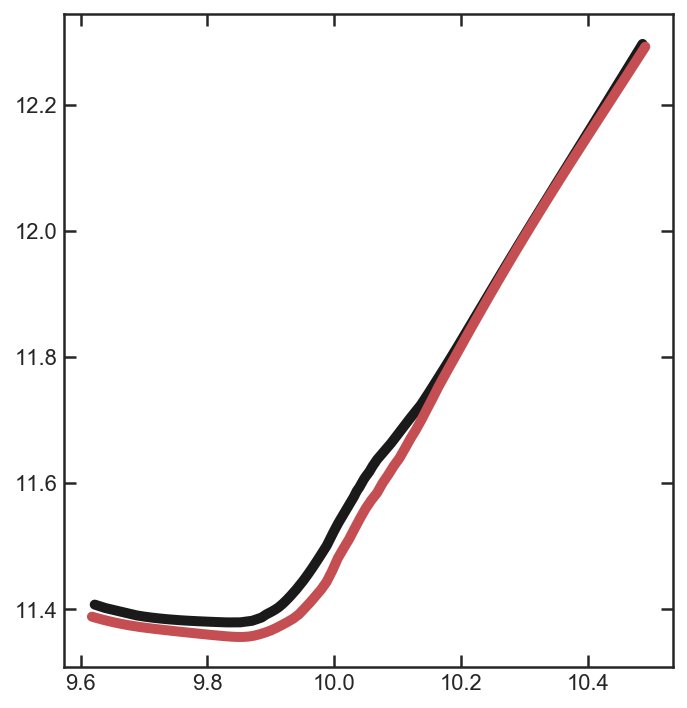

In [16]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[12,6])
ax1 = plt.subplot(gs[0])
start = time()
z = lowess(cosmo.lookback_time(mdb.z_50),np.log10(mdb.Sigma1))
end = time()
print(end - start)
plt.plot(z[:, 0], z[:, 1], linewidth=5, color = 'k')

# ax2 = plt.subplot(gs[1])
start = time()
regsDF, evalDF = LOWESS(np.log10(mdb.Sigma1.values),cosmo.lookback_time(mdb.z_50).value, alpha = 0.6666)
end = time()
print(end - start)

l_x  = evalDF['v'].values
l_y  = evalDF['g'].values
plt.plot(l_x, l_y, linewidth=5, color = 'r')

In [87]:
Sx_range = np.linspace(np.log10(mdb.Sigma1.values).min(), np.log10(mdb.Sigma1.values).max(), 1000)

smooth_grid = []

for i in range(1000):
    IDX = np.random.choice(mdb.index.values,len(mdb.index))
    
#     z = lowess(cosmo.lookback_time(mdb.z_50[IDX].values).value,np.log10(mdb.Sigma1[IDX].values))

#     l_x = z[:, 0]
#     l_y = z[:, 1]
    
    regsDF, evalDF = LOWESS(np.log10(mdb.Sigma1[IDX].values),cosmo.lookback_time(mdb.z_50[IDX]).value, alpha = 0.6)

    l_x  = evalDF['v'].values
    l_y  = evalDF['g'].values
    
    
    smooth_grid.append(interp1d(l_x, l_y, bounds_error=False, fill_value=0)(Sx_range))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:93: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [88]:
smooth_grid = np.array(smooth_grid)

Sm = []
Sh = []
Sl = []

for i in range(len(Sx_range)):
    Tarray = smooth_grid.T[i]
    
    
    Sm.append(np.percentile(Tarray[Tarray > 0], 50))
    Sh.append(np.percentile(Tarray[Tarray > 0], 84))
    Sl.append(np.percentile(Tarray[Tarray > 0], 16))

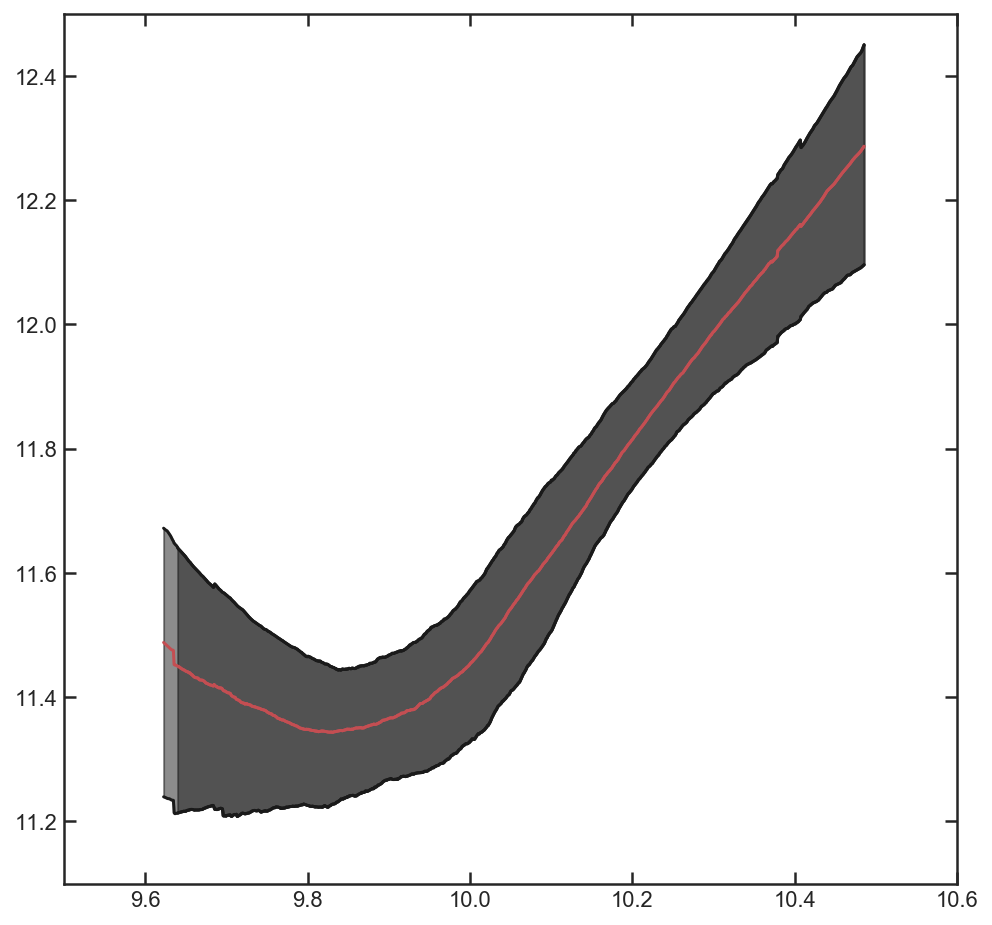

In [90]:
plt.figure(figsize = [8,8])
plt.plot(Sx_range[20:], Sm[20:], 'r')
plt.plot(Sx_range[20:], Sh[20:], 'k')
plt.plot(Sx_range[20:], Sl[20:], 'k')
plt.fill_between(Sx_range[20:], Sl[20:], Sh[20:], alpha = 0.5, color = 'k')
plt.ylim(11.1, 12.5)
plt.xlim(9.5,10.6)
plt.plot(Sx_range, Sm, 'r')
plt.plot(Sx_range, Sh, 'k')
plt.plot(Sx_range, Sl, 'k')
plt.fill_between(Sx_range, Sl, Sh, alpha = 0.5, color = 'k')

In [95]:
np.save('../data/plot_points/Sig1_lowess', [Sx_range, Sm, Sl, Sh])

In [64]:
z = lowess(cosmo.lookback_time(mdb.z_50.values).value, np.log10(mdb.Sigma1.values))

l_x = z[:, 0]
l_y = z[:, 1]

imn = interp1d(l_x, l_y)

sd = lowess(np.sqrt((cosmo.lookback_time(mdb.z_50).value - imn(np.log10(mdb.Sigma1.values)))**2), 
            np.log10(mdb.Sigma1.values), frac = 0.7)

s_x = sd[:, 0]
s_y = sd[:, 1]

regsDF, evalDF = LOWESS(np.log10(mdb.Sigma1.values),
                        np.sqrt((cosmo.lookback_time(mdb.z_50).value - imn(np.log10(mdb.Sigma1.values)))**2), alpha = 0.7)

t_x  = evalDF['v'].values
t_y  = evalDF['g'].values


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:95: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:107: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



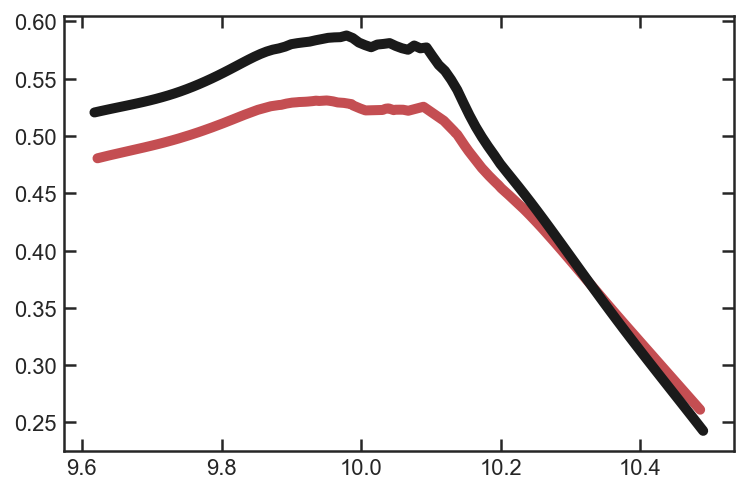

In [65]:
plt.plot(s_x, s_y, linewidth=5, color = 'r')
plt.plot(t_x, t_y, linewidth=5, color = 'k')

In [93]:
Sx_range = np.linspace(np.log10(mdb.Sigma1.values).min(), np.log10(mdb.Sigma1.values).max(), 1000)

smooth_grid_sd = []

for i in range(1000):
    IDX = np.random.choice(mdb.index.values,len(mdb.index))
    
#     z = lowess(cosmo.lookback_time(mdb.z_50[IDX].values).value,np.log10(mdb.Sigma1[IDX].values), frac = 0.7,)

#     l_x = z[:, 0]
#     l_y = z[:, 1]
    

#     sd = lowess(np.sqrt((cosmo.lookback_time(mdb.z_50[IDX]).value - imn(np.log10(mdb.Sigma1[IDX].values)))**2), 
#                 np.log10(mdb.Sigma1[IDX].values), frac = 0.7)

#     s_x = sd[:, 0]
#     s_y = sd[:, 1]

    regsDF, evalDF = LOWESS(np.log10(mdb.Sigma1[IDX].values),cosmo.lookback_time(mdb.z_50[IDX]).value, alpha = 0.7)

    l_x  = evalDF['v'].values
    l_y  = evalDF['g'].values
    imn = interp1d(l_x, l_y)

    regsDF, evalDF = LOWESS(np.log10(mdb.Sigma1[IDX].values),
                                np.sqrt((cosmo.lookback_time(mdb.z_50[IDX]).value - imn(np.log10(mdb.Sigma1[IDX].values)))**2), alpha = 0.7)

    s_x  = evalDF['v'].values
    s_y  = evalDF['g'].values
    
    smooth_grid_sd.append(interp1d(s_x, s_y, bounds_error=False, fill_value=0)(Sx_range))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:93: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [96]:
smooth_grid_sd = np.array(smooth_grid_sd)

Sdm = []
Sdh = []
Sdl = []

for i in range(len(Sx_range)):
    Tarray = smooth_grid_sd.T[i]
    
    Sdm.append(np.percentile(Tarray[Tarray > 0], 50))
    Sdh.append(np.percentile(Tarray[Tarray > 0], 84))
    Sdl.append(np.percentile(Tarray[Tarray > 0], 16))

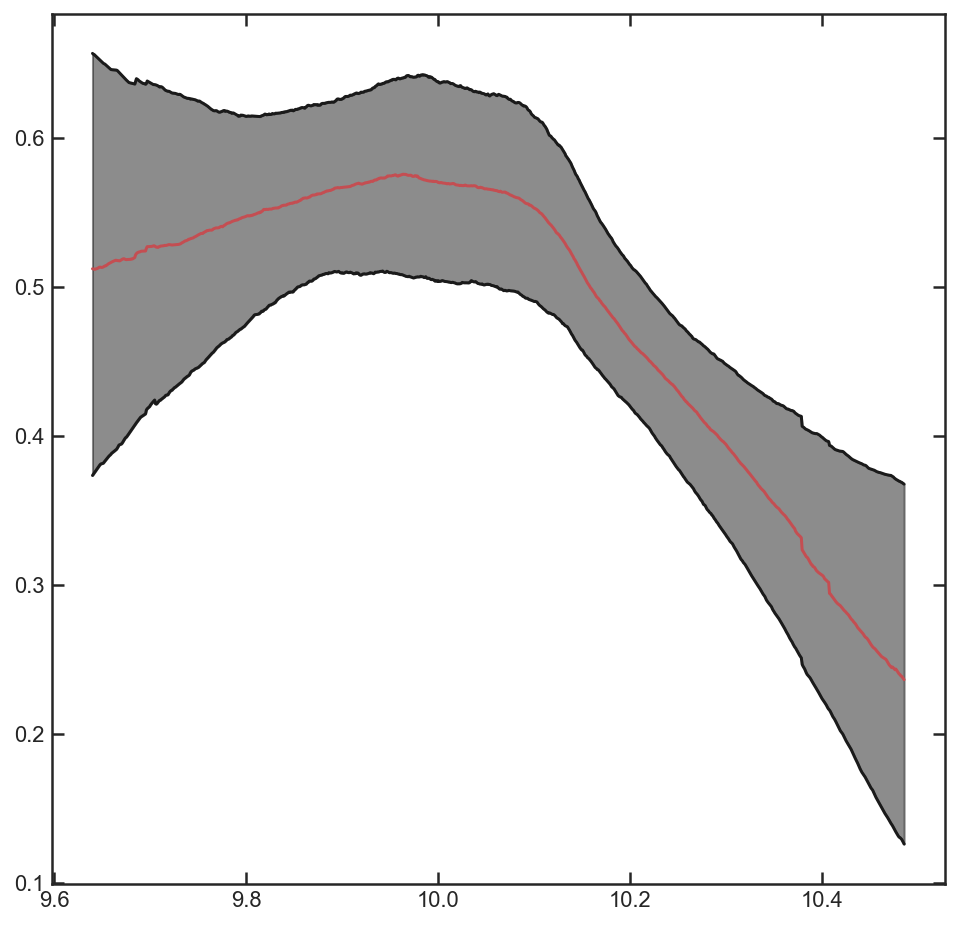

In [97]:
plt.figure(figsize = [8,8])
plt.plot(Sx_range[20:], Sdm[20:], 'r')
plt.plot(Sx_range[20:], Sdh[20:], 'k')
plt.plot(Sx_range[20:], Sdl[20:], 'k')
plt.fill_between(Sx_range[20:], Sdl[20:], Sdh[20:], alpha = 0.5, color = 'k')
# plt.ylim(11.1, 12.5)
# plt.xlim(9.5,10.6)

In [98]:
np.save('../data/plot_points/Sig1_sd_lowess', [Sx_range, Sdm, Sdl, Sdh])

In [99]:
Mx_range = np.linspace(mdb.lmass.values.min(), mdb.lmass.values.max(), 1000)

smooth_grid_m = []

for i in range(1000):
    IDX = np.random.choice(mdb.index.values,len(mdb.index))
    
#     z = lowess(cosmo.lookback_time(mdb.z_50[IDX].values).value, mdb.lmass[IDX].values, frac = 0.55)

#     l_x = z[:, 0]
#     l_y = z[:, 1]
    
    regsDF, evalDF = LOWESS(mdb.lmass[IDX].values,cosmo.lookback_time(mdb.z_50[IDX]).value, alpha = 0.55)

    l_x  = evalDF['v'].values
    l_y  = evalDF['g'].values
    
    
    smooth_grid_m.append(interp1d(l_x, l_y, bounds_error=False, fill_value=0)(Mx_range))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:93: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [100]:
smooth_grid_m = np.array(smooth_grid_m)

Mm = []
Mh = []
Ml = []

for i in range(len(Mx_range)):
    Tarray = smooth_grid_m.T[i]
      
    Mm.append(np.percentile(Tarray[Tarray > 0], 50))
    Mh.append(np.percentile(Tarray[Tarray > 0], 84))
    Ml.append(np.percentile(Tarray[Tarray > 0], 16))

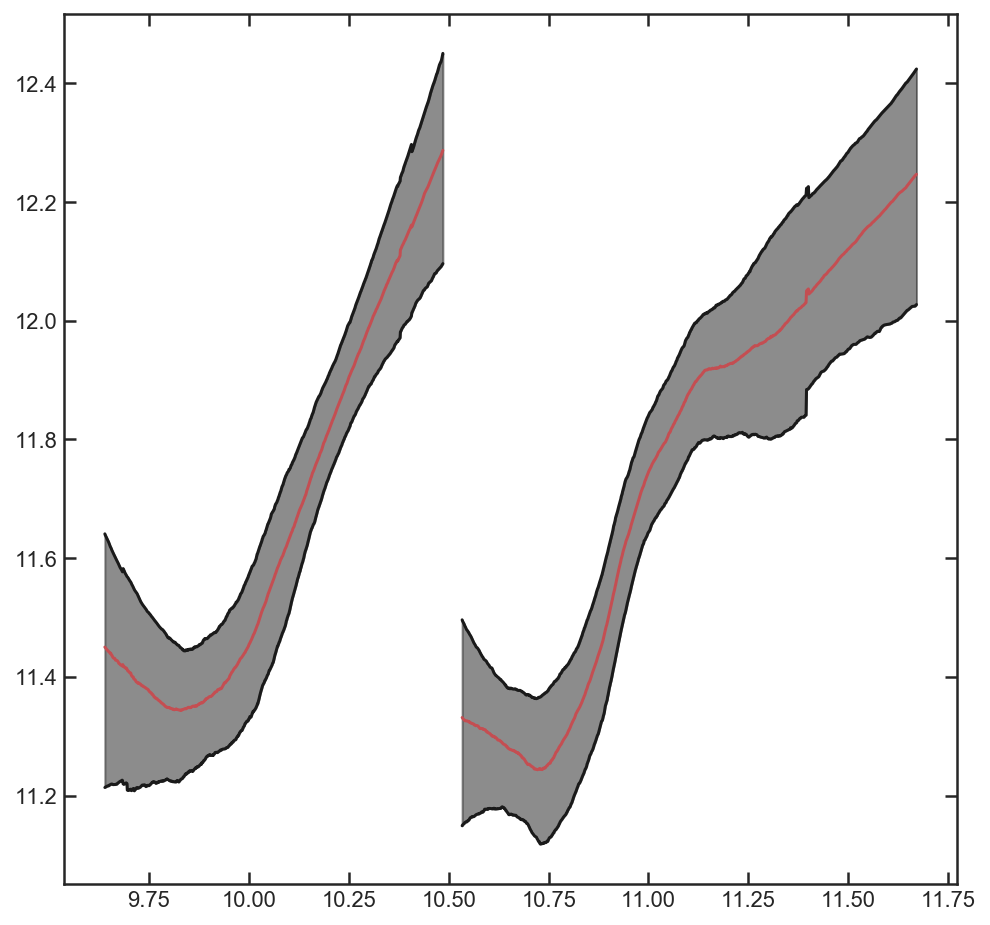

In [101]:
plt.figure(figsize = [8,8])
plt.plot(Mx_range[28:], Mm[28:], 'r')
plt.plot(Mx_range[28:], Mh[28:], 'k')
plt.plot(Mx_range[28:], Ml[28:], 'k')
plt.fill_between(Mx_range[28:], Ml[28:], Mh[28:], alpha = 0.5, color = 'k')

plt.plot(Sx_range[20:], Sm[20:], 'r')
plt.plot(Sx_range[20:], Sh[20:], 'k')
plt.plot(Sx_range[20:], Sl[20:], 'k')
plt.fill_between(Sx_range[20:], Sl[20:], Sh[20:], alpha = 0.5, color = 'k')

In [102]:
np.save('../data/plot_points/mass_lowess', [Mx_range, Mm, Ml, Mh])

In [107]:
Cmdb = mdb.query('Sigma1 > {0}'.format(10**10))
Emdb = mdb.query('Sigma1 < {0}'.format(10**10))


Cx_range = np.linspace(Cmdb.zgrism.values.min(), Cmdb.zgrism.values.max(), 1000)
Ex_range = np.linspace(Emdb.zgrism.values.min(), Emdb.zgrism.values.max(), 1000)

smooth_C_grid = []
smooth_E_grid = []

for i in range(1000):
    IDX = np.random.choice(Cmdb.index.values,len(Cmdb.index))
    
    regsDF, evalDF = LOWESS(Cmdb.zgrism[IDX].values, cosmo.lookback_time(Cmdb.z_50[IDX]).value, alpha = 0.6)

    c_x  = evalDF['v'].values
    c_y  = evalDF['g'].values
    
    smooth_C_grid.append(interp1d(c_x, c_y, bounds_error=False, fill_value=0)(Cx_range))
    
    
    IDX = np.random.choice(Emdb.index.values,len(Emdb.index))
    
    regsDF, evalDF = LOWESS(Emdb.zgrism[IDX].values, cosmo.lookback_time(Emdb.z_50[IDX]).value, alpha = 0.6)

    e_x  = evalDF['v'].values
    e_y  = evalDF['g'].values
    
    smooth_E_grid.append(interp1d(e_x, e_y, bounds_error=False, fill_value=0)(Ex_range))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:93: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [108]:
smooth_C_grid = np.array(smooth_C_grid)
smooth_E_grid = np.array(smooth_E_grid)

Cm = []
Ch = []
Cl = []
Em = []
Eh = []
El = []

for i in range(len(Cx_range)):
    Tarray = smooth_C_grid.T[i]
      
    Cm.append(np.percentile(Tarray[Tarray > 0], 50))
    Ch.append(np.percentile(Tarray[Tarray > 0], 84))
    Cl.append(np.percentile(Tarray[Tarray > 0], 16))
    
for i in range(len(Ex_range)):
    Tarray = smooth_E_grid.T[i]
      
    Em.append(np.percentile(Tarray[Tarray > 0], 50))
    Eh.append(np.percentile(Tarray[Tarray > 0], 84))
    El.append(np.percentile(Tarray[Tarray > 0], 16))

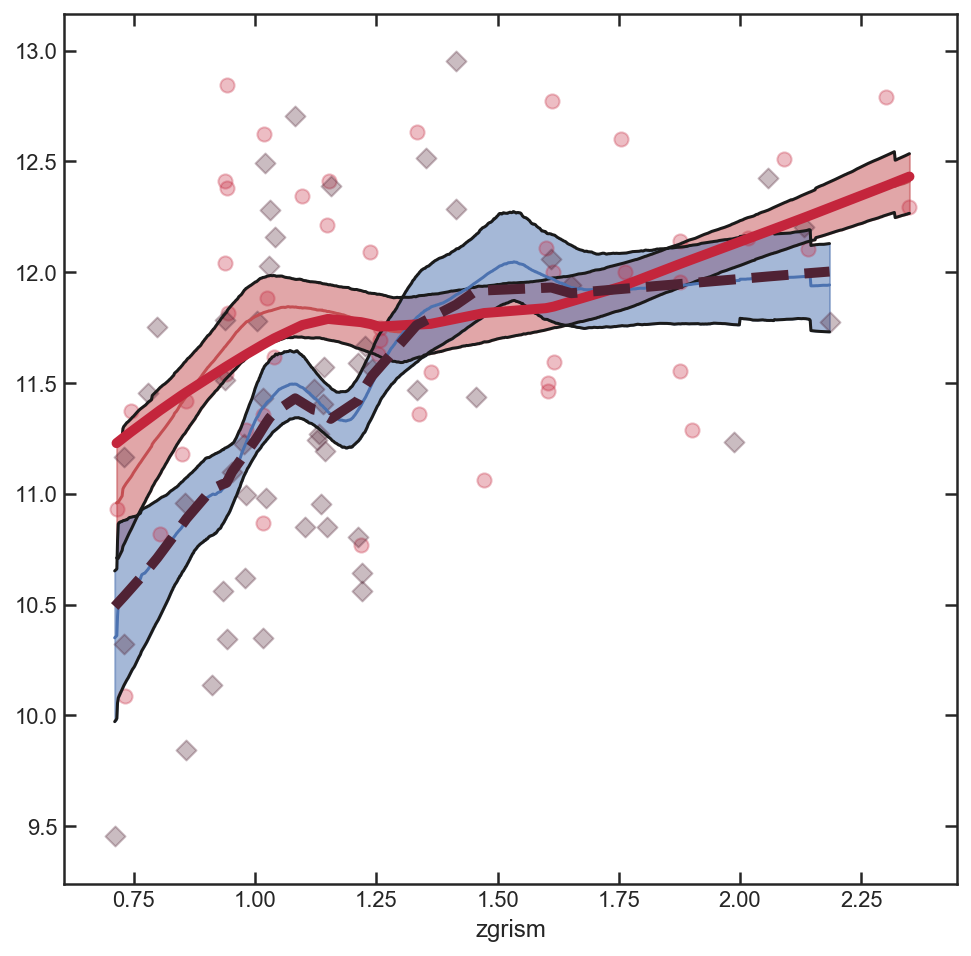

In [115]:
plt.figure(figsize = [8,8])
plt.plot(Cx_range, Cm, 'r')
plt.plot(Cx_range, Ch, 'k')
plt.plot(Cx_range, Cl, 'k')
plt.fill_between(Cx_range, Cl, Ch, alpha = 0.5, color = 'r')

plt.plot(Ex_range, Em, 'b')
plt.plot(Ex_range, Eh, 'k')
plt.plot(Ex_range, El, 'k')
plt.fill_between(Ex_range, El, Eh, alpha = 0.5, color = 'b')

sea.regplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),lowess = True,
            color = '#C4253C',truncate=True, ci = 68, scatter_kws={'alpha':0.3, 's':50}
            , line_kws= {'linewidth':5})
sea.regplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),lowess = True,
            color = '#502234',truncate=True, ci = 68, scatter_kws={'alpha':0.3, 's':50}, 
            marker = 'D', line_kws= {'linestyle' : '--', 'linewidth':5})

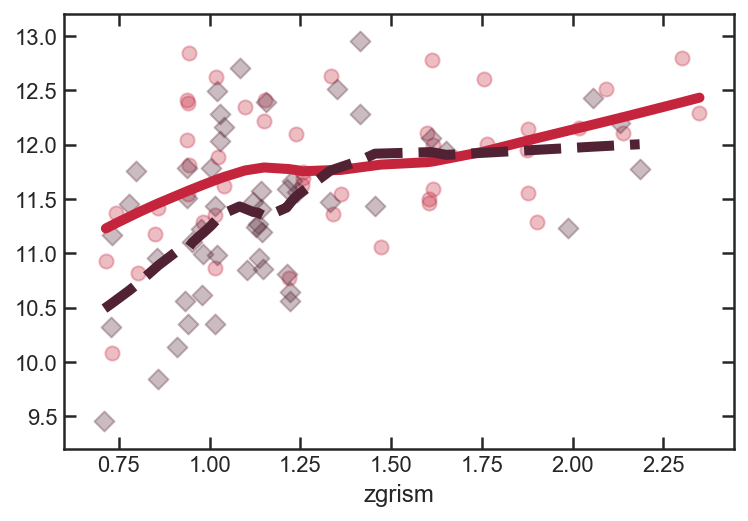

In [111]:
ax3 = plt.subplot()
Cmdb = mdb.query('Sigma1 > {0}'.format(10**10))
Emdb = mdb.query('Sigma1 < {0}'.format(10**10))
sea.regplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),lowess = True,
            color = '#C4253C',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3, 's':50}
            , line_kws= {'linewidth':5})
sea.regplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),lowess = True,
            color = '#502234',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3, 's':50}, 
            marker = 'D', line_kws= {'linestyle' : '--', 'linewidth':5})

In [116]:
np.save('../data/plot_points/compact_lowess', [Cx_range, Cm, Cl, Ch])
np.save('../data/plot_points/extend_lowess', [Ex_range, Em, El, Eh])

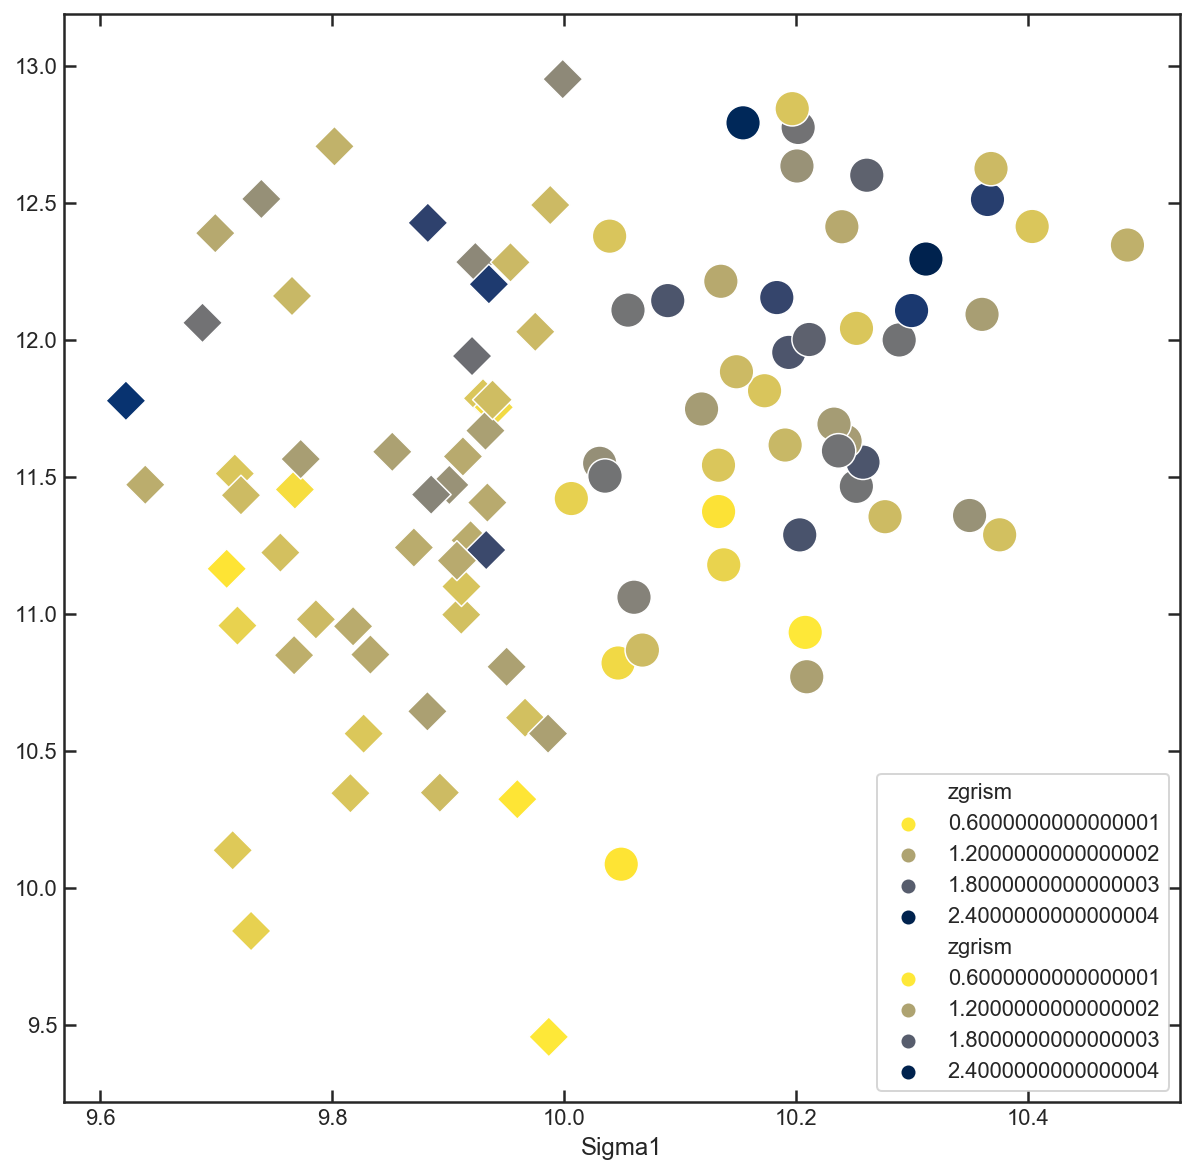

In [148]:
plt.figure(figsize=[10,10])
sea.scatterplot(np.log10(mdb.query('Sigma1 > 10**10').Sigma1), cosmo.lookback_time(mdb.query('Sigma1 > 10**10').z_50),
            alpha=1, s=300, hue = mdb.query('Sigma1 > 10**10').zgrism, palette = 'cividis_r', hue_norm = (min(mdb.zgrism),max(mdb.zgrism)))

sea.scatterplot(np.log10(mdb.query('Sigma1 < 10**10').Sigma1), cosmo.lookback_time(mdb.query('Sigma1 < 10**10').z_50),marker='D',
            alpha=1, s=200, hue = mdb.query('Sigma1 < 10**10').zgrism, palette = 'cividis_r', hue_norm = (min(mdb.zgrism),max(mdb.zgrism)))
